# Objective: Feature Engineering

Load tables and merge them together into one big table. Will then add new features to this.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now, let us load all tables and get to the final table (without adding 'add_to_cart_order_mod' col) -- order_products__prior_df_mod2 -- we had at the end of our last notebook to continue with our Instacart Basket Analysis.

In [30]:
aisles = pd.read_csv('aisles.csv')

In [31]:
departments = pd.read_csv('departments.csv')

In [32]:
order_products__prior = pd.read_csv('order_products__prior.csv')

In [33]:
order_products__train = pd.read_csv('order_products__train.csv')

In [34]:
orders = pd.read_csv('orders.csv')

In [35]:
products = pd.read_csv('products.csv')

In [36]:
order_products__prior_df = pd.merge(order_products__prior, products, on='product_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, aisles, on='aisle_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, departments, on='department_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, orders, on='order_id', how='left')
order_products__prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In order to see which features we need to keep to transform and make better features for prediction, we need to see which columns are numerical.

In [37]:
order_products__prior_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
order_id                  int64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
aisle                     object
department                object
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.9+ GB


Columns to drop will be: product_name, aisle, department and eval_set.

In [38]:
#Extract from main table numerical data only (no strings/object-type data)
order_products__prior_df_mod = order_products__prior_df.drop(['product_name', 'aisle', 'department', 'eval_set'], axis=1)
order_products__prior_df_mod.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,86,16,202279,3,5,9,8.0
1,2,28985,2,1,83,4,202279,3,5,9,8.0
2,2,9327,3,0,104,13,202279,3,5,9,8.0
3,2,45918,4,1,19,13,202279,3,5,9,8.0
4,2,30035,5,0,17,13,202279,3,5,9,8.0


Now, we need to drop all NaN's from this table to get the table we need prior to Feature Engineering.

In [39]:
order_products__prior_df_mod2 = order_products__prior_df_mod.dropna()

In [40]:
#Check:
order_products__prior_df_mod2.shape

(30356421, 11)

Great! We are ready to start our Feature Engineering.

# Mindset

When thinking about reordering/purchasing something again, need to consider what would be part of that decision. What would matter most and how can that factor be represented by data table given. Also, features chosen would be in light of what EDA showed. For example, when looking at data, where was there a huge **bias towards reorders**? This would shed light on what features contribute to reorders and help narrow down which features to focus on when making new features.

After looking at EDA, below are features that contributed most to reorders. This will be looked into futher by calculating correlation coefficient.

**add_to_cart_order, aisle_id, order_hour_of_day**

Now, let us see what correlation_coefficient calculation says about that.

In [41]:
order_products__prior_df_mod2.corr()['reordered'].sort_values()

add_to_cart_order        -0.145232
days_since_prior_order   -0.132814
department_id            -0.043320
order_hour_of_day        -0.021142
order_dow                -0.008801
user_id                  -0.000866
order_id                 -0.000260
product_id                0.004243
aisle_id                  0.004421
order_number              0.250973
reordered                 1.000000
Name: reordered, dtype: float64

According to the calculation, **order_number, order_dow, order_hour_of_day** are the top 3 non-id features that contribute to reordered.

Order_hour_of_day is the only feature in common between EDA and corr coeff outputs.

Let's look at correlating features using a heatmap to see which feature/s have the highest correlation.

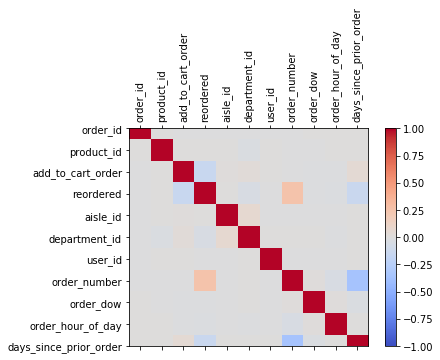

In [42]:
corr = order_products__prior_df_mod2.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(order_products__prior_df_mod2.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(order_products__prior_df_mod2.columns)
ax.set_yticklabels(order_products__prior_df_mod2.columns)
plt.show()

When looking at reordered in both dimensions, the features (non id's) that are highest correlated with it are:
**order_number, days_since_prior_order** Another interesting finding from this is that there is a high correlation between **days_since_prior_order and order_number**

The only common feature from this output and correlation coefficient is order_number. 

So for our feature engineering, features to focus on and derive new features from will be:

**order_number, days_since_prior_order, add_to_cart_order, order_dow, order_hour_of_day**

In [43]:
order_products__prior_df_mod2.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,86,16,202279,3,5,9,8.0
1,2,28985,2,1,83,4,202279,3,5,9,8.0
2,2,9327,3,0,104,13,202279,3,5,9,8.0
3,2,45918,4,1,19,13,202279,3,5,9,8.0
4,2,30035,5,0,17,13,202279,3,5,9,8.0


In [44]:
#Getting rid of more irrelevant columns before adding relevant features.
final = order_products__prior_df_mod.drop(['order_id', 'product_id', 'aisle_id', 'department_id', 'user_id'], axis=1)

final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,1,3,5,9,8.0
1,2,1,3,5,9,8.0
2,3,0,3,5,9,8.0
3,4,1,3,5,9,8.0
4,5,0,3,5,9,8.0


In [45]:
final['order_number*days_since_prior_order'] = final['order_number']*final['days_since_prior_order']
final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number*days_since_prior_order
0,1,1,3,5,9,8.0,24.0
1,2,1,3,5,9,8.0,24.0
2,3,0,3,5,9,8.0,24.0
3,4,1,3,5,9,8.0,24.0
4,5,0,3,5,9,8.0,24.0


In [46]:
final['order_number*reordered'] = final['order_number']*final['reordered']
final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number*days_since_prior_order,order_number*reordered
0,1,1,3,5,9,8.0,24.0,3
1,2,1,3,5,9,8.0,24.0,3
2,3,0,3,5,9,8.0,24.0,0
3,4,1,3,5,9,8.0,24.0,3
4,5,0,3,5,9,8.0,24.0,0


In [47]:
final['add_to_cart_order2'] = final['add_to_cart_order'] + 15
final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number*days_since_prior_order,order_number*reordered,add_to_cart_order2
0,1,1,3,5,9,8.0,24.0,3,16
1,2,1,3,5,9,8.0,24.0,3,17
2,3,0,3,5,9,8.0,24.0,0,18
3,4,1,3,5,9,8.0,24.0,3,19
4,5,0,3,5,9,8.0,24.0,0,20


In [48]:
final['order_dow2'] = final['order_dow'] + 8
final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number*days_since_prior_order,order_number*reordered,add_to_cart_order2,order_dow2
0,1,1,3,5,9,8.0,24.0,3,16,13
1,2,1,3,5,9,8.0,24.0,3,17,13
2,3,0,3,5,9,8.0,24.0,0,18,13
3,4,1,3,5,9,8.0,24.0,3,19,13
4,5,0,3,5,9,8.0,24.0,0,20,13


In [49]:
final['order_hour_of_day2'] = final['order_hour_of_day']*.5
final.head()

,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number*days_since_prior_order,order_number*reordered,add_to_cart_order2,order_dow2,order_hour_of_day2
0,1,1,3,5,9,8.0,24.0,3,16,13,4.5
1,2,1,3,5,9,8.0,24.0,3,17,13,4.5
2,3,0,3,5,9,8.0,24.0,0,18,13,4.5
3,4,1,3,5,9,8.0,24.0,3,19,13,4.5
4,5,0,3,5,9,8.0,24.0,0,20,13,4.5


Next up: We can train our Decision Tree model based on original tree and then train our model with new features and see how each model differs in performance!